In [1]:
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.stats import spearmanr
from pathlib import Path

In [2]:
sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.dataloading import prepare_full_set, read_tganom_predictand
from Hybrid.dataprep import test_trainval_split, filter_predictor_set, j_measure, perkins

sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.utils import collapse_restore_multiindex

2021-12-01 14:00:48.042029: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 14:00:48.042053: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
#leadtimepool = [4,5,6,7,8]
def compute_imps(targetname, leadtimepool, ndaythreshold = 7, tganomkwargs = {}, with_gmst = True):
    """ Returns j_measures and 1-p_measures compute on the trainval set 
    tganomkwargs should contain booksname, climname, modelclimname
    """
    target_region = 9
    predictors, forc, obs = prepare_full_set(targetname, ndaythreshold = ndaythreshold, predictand_cluster = target_region, leadtimepool = leadtimepool)
    _, obs_trainval, _ = test_trainval_split(obs, crossval = True, nfolds = 3, balanced = True)
    _, pred_trainval, _ = test_trainval_split(predictors, crossval = True, nfolds = 3, balanced = True)
    if tganomkwargs:
        obs_trainval, _ = read_tganom_predictand(clustid = target_region, separation = leadtimepool, **tganomkwargs)
        obs_trainval = obs_trainval.loc[pred_trainval.index,:]
    # Test what a trend variable does. Not a trend in probability
    # So perhaps just global mean surface temperature?
    if with_gmst:
        trend_path = '/nobackup/users/straaten/predsets/tg_monthly_global_mean_surface_only_trend.nc'
        trend = xr.open_dataarray(trend_path).to_dataframe()
        trend.columns = pd.MultiIndex.from_tuples([('tg-anom',31,0,'mean')], names = pred_trainval.columns.names)
        pred_trainval = pred_trainval.join(trend, how = 'left')
    _, js = filter_predictor_set(pred_trainval, obs_trainval.iloc[:,-1].astype(bool), how = j_measure, return_measures = True, nmost_important = 1, nbins=10)
    _, ps = filter_predictor_set(pred_trainval, obs_trainval.iloc[:,-1].astype(bool), how = perkins, return_measures = True, nmost_important = 1, nbins = 10)
    oneminps = 1 - ps
    oneminps.name = f'1-{ps.name}'
    return pd.concat([js, oneminps], axis = 1)

def load_sequential_imps(name: str, npreds: int = None):
    """
    Loads the sequential forward importances. (Ranks)
    can be single (lots of predictors) or multi (only n_depth of predictors)
    you can supply the total number of predictors (not inferable from size of the multi file)
    """
    basepath = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/emp_duplicated/')
    temp = pd.read_csv(basepath / f'{name}.csv', index_col = 0, header = 0)
    collapse_restore_multiindex(temp, axis = 1, names = ['variable','timeagg','clustid','metric'], dtypes = [str,int,int,str], inplace = True)
    if (npreds is None):
        npreds = len(temp.columns)
    ranks = npreds - temp.loc['rank']
    return ranks
    
def scatter(df, xcol, ycol, n_names = 10, title: str = None):
    """
    Plots two columns of the dataframe (potentially sorted) against each other
    names the bottom n_names rows by their index value
    """
    fig, ax = plt.subplots()
    ax.scatter(x = df[xcol], y = df[ycol], alpha = 0.3)
    try: 
        trendpoint = df.loc[('tg-anom',31,0,'mean'),:]
        ax.scatter(x = trendpoint.loc[xcol], y = trendpoint.loc[ycol], color = 'red')
    except KeyError:
        pass
    for i in range(n_names):
        #ax.text(x = df[xcol].iloc[-i], y = df[ycol].iloc[-i], s = str(df.index[-i]))
        ax.annotate(str(df.index[i]), xy = (df[xcol].iloc[i],df[ycol].iloc[i]), xycoords = 'data',
                    xytext=(1.05,np.linspace(1,0,num=n_names)[i]), textcoords='axes fraction',
                   arrowprops=dict(color='grey', shrink=0.01, width = 0.2, headwidth = 0.8, zorder = 0))
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    if not (title is None):
        ax.set_title(title)
    return fig, ax

## Leadtime 19-21

In [5]:
# First the non-sequential importances (potentially influenced by trends)
tgex7 = compute_imps(targetname = 'books_paper3-2_tg-ex-q0.75-21D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv', leadtimepool = list(range(19,22)))
tgex4 = compute_imps(targetname = 'books_paper3-2_tg-ex-q0.75-21D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv', ndaythreshold= 4, leadtimepool = list(range(19,22)))
tganomkwargs = dict(booksname = 'books_paper3-1_tg-anom_JJA_45r1_21D-roll-mean_15-t2m-q095-adapted-mean.csv',climname = 'tg-anom_clim_1998-06-07_2019-10-31_21D-roll-mean_15-t2m-q095-adapted-mean_5_5_q0.5', modelclimname = 'tg-anom_45r1_1998-06-07_2019-08-31_21D-roll-mean_15-t2m-q095-adapted-mean_5_5_q0.5')
tganom21 = compute_imps(targetname = 'books_paper3-2_tg-ex-q0.75-21D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv', leadtimepool = list(range(19,22)), tganomkwargs = tganomkwargs)
# Now the sequential stepwise importances.
# CURRENTLY NOT the fully projected timeseries.
tgex7_single = load_sequential_imps(name = 'tg-ex-q0.75-21D_ge7D_sep19-21_single_d20_b3')
tgex7_multi = load_sequential_imps(name = 'tg-ex-q0.75-21D_ge7D_sep19-21_multi_d20_b3', npreds = len(tgex7_single))

/usr/people/straaten/Documents/Hybrid/Hybrid/dataloading.py:204: UserWarning: picking values from pattern at 21 which got projected onto the shorter leadtimes in [19, 20, 21]
  warnings.warn(f'picking values from pattern at {longest_shared_leadtime} which got projected onto the shorter leadtimes in {leadtimepool}')


Binarized target: n_hotdays >= 7, onehot-encoded


/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:40: UserWarning: using alpha 0.9 for forecast categorization
  warnings.warn(f'using alpha {alpha} for forecast categorization')
/usr/people/straaten/Documents/Hybrid/Hybrid/dataloading.py:204: UserWarning: picking values from pattern at 21 which got projected onto the shorter leadtimes in [19, 20, 21]
  warnings.warn(f'picking values from pattern at {longest_shared_leadtime} which got projected onto the shorter leadtimes in {leadtimepool}')


Binarized target: n_hotdays >= 4, onehot-encoded


/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:40: UserWarning: using alpha 0.9 for forecast categorization
  warnings.warn(f'using alpha {alpha} for forecast categorization')
/usr/people/straaten/Documents/Hybrid/Hybrid/dataloading.py:204: UserWarning: picking values from pattern at 21 which got projected onto the shorter leadtimes in [19, 20, 21]
  warnings.warn(f'picking values from pattern at {longest_shared_leadtime} which got projected onto the shorter leadtimes in {leadtimepool}')


Binarized target: n_hotdays >= 7, onehot-encoded
climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction


/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:40: UserWarning: using alpha 0.9 for forecast categorization
  warnings.warn(f'using alpha {alpha} for forecast categorization')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [16]:
# All combined.
lead1921 = pd.concat([tgex7,tgex4,tganom21, tgex7_multi, tgex7_single], axis = 1, keys = ['tgex7','tgex4','tganom21','tgex7_multi','tgex7_single'])

### j_measure vs perkins
high correspondence between measures. Trend is prominent in both, perhaps a bit more so in perkins

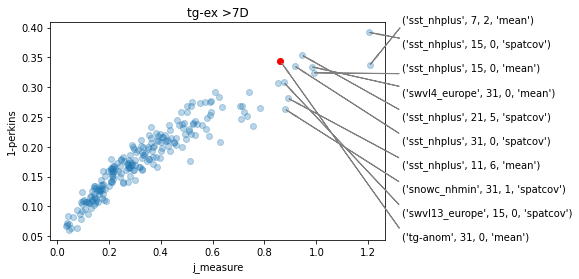

In [64]:
df = lead1921['tgex7']
scatter(df.sort_values('j_measure', ascending = False), xcol = 'j_measure', ycol = '1-perkins', title = 'tg-ex >7D')
plt.show()

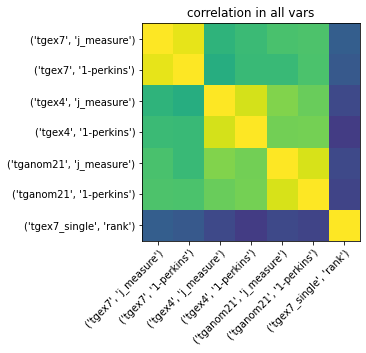

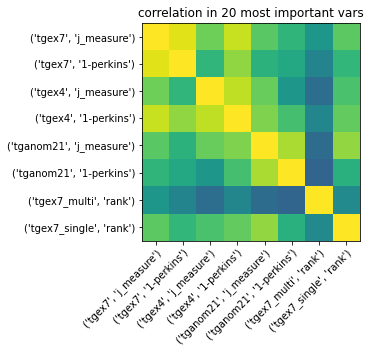

In [55]:
def cormatrix(no_missing: pd.DataFrame, title = ''):
    fig, ax = plt.subplots()
    im = ax.imshow(spearmanr(no_missing.values, axis = 0)[0], vmin = 0, vmax = 1)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(no_missing.columns)))
    ax.set_xticklabels(no_missing.columns.to_flat_index().values)
    ax.set_yticks(np.arange(len(no_missing.columns)))
    ax.set_yticklabels(no_missing.columns.to_flat_index().values)
    ax.set_title(title)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    return fig, ax

df_allvars = lead1921.drop('tgex7_multi', axis = 1).dropna(how = 'any') # Drops the tg-anom 31 and z-reg 21 -1
cormatrix(df_allvars, title = 'correlation in all vars')
plt.show()
df_20vars = lead1921.dropna(how = 'any')
cormatrix(df_20vars, title = 'correlation in 20 most important vars')
plt.show()

Although the latter matrix with correlation is more noisy (only 20 samples). We do see that singlepass gets more agreeable with the other rankings than when the whole set is evaluated. In the small set, it is multipass that disagrees the most with the measures and of those it disagrees most with tg-anom. This confirms that it seems to be selecting a different set.

### singlepass and multipass vs j_measure
Are combinations surprising, are at least the top predictors retained?

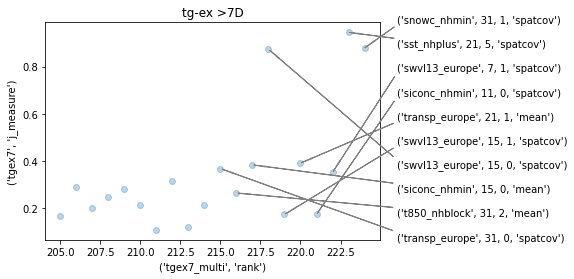

In [65]:
scatter(lead1921.sort_values(('tgex7_multi','rank'), ascending = False), xcol = ('tgex7_multi','rank'), ycol = ('tgex7','j_measure'), 
        title = 'tg-ex >7D: multipass selection')
plt.show()

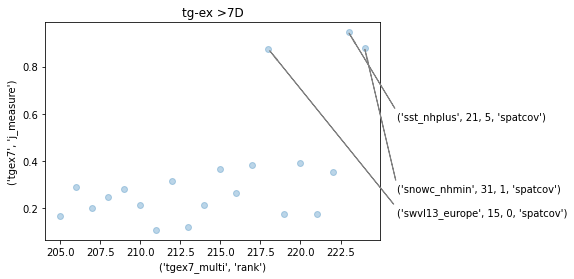

In [66]:
scatter(lead1921.sort_values(('tgex7','j_measure'), ascending = False), xcol = ('tgex7_multi','rank'), ycol = ('tgex7','j_measure'), 
        title = 'tg-ex >7D: j_measure selection')
plt.show()

We see that only three predictors are retained by multipass. All others included by multipass are actually low in the ranking by j_measure. Unfortunately these are not the three top predictors in multipass (such that we can cutoff the search). Lets look at singlepass.

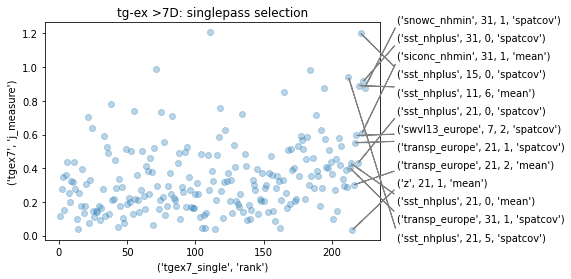

In [73]:
scatter(lead1921.sort_values(('tgex7_single','rank'), ascending = False), xcol = ('tgex7_single','rank'), ycol = ('tgex7','j_measure'), 
        title = 'tg-ex >7D: singlepass selection', n_names = 13)
plt.show()

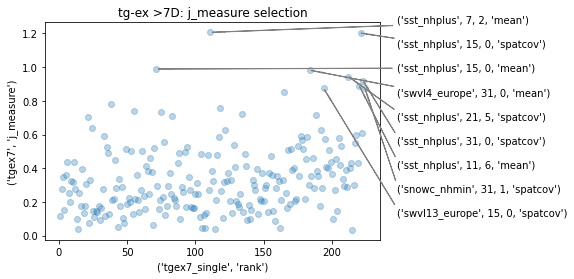

In [70]:
scatter(lead1921.sort_values(('tgex7','j_measure'), ascending = False), xcol = ('tgex7_single','rank'), ycol = ('tgex7','j_measure'), 
        title = 'tg-ex >7D: j_measure selection')
plt.show()

Singlepass includes a predictor that belongs to the lowest of j-measures. The converse is not true for the j_measure set (in the top three it does include 2 mean predictors that are not very important according singlepass).
Bit worrying is that singlepass misses a known top predictor (sst_nhplus,21,5,spatcov) in its top 10 (only as 13th).

### tganom vs tg-ex in terms of j_measure
tganom provides sets that differ the most from multipass selections. Are combinations surprising, are at least the top predictors retained?

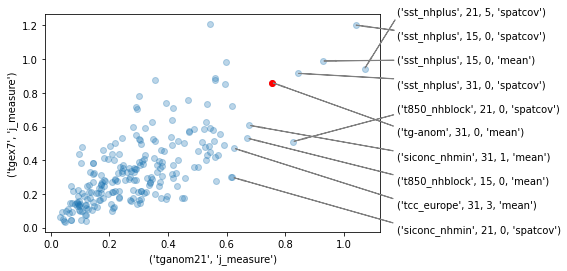

In [76]:
scatter(lead1921.sort_values(('tganom21','j_measure'), ascending = False), xcol = ('tganom21','j_measure'), ycol = ('tgex7','j_measure'))
plt.show()

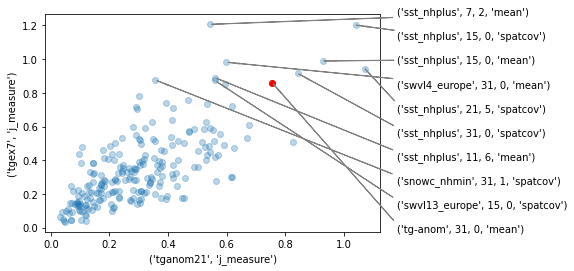

In [75]:
scatter(lead1921.sort_values(('tgex7','j_measure'), ascending = False), xcol = ('tganom21','j_measure'), ycol = ('tgex7','j_measure'))
plt.show()

Tg-anom seems to miss the snowcover predictor (eurasian one). which was actually top for tg-ex + j-measure and definitely top for tg-ex + stepwise selection.

In all combinations above the amount of spatcov features > mean features

# Leadtime 12-15
Has potentially better skill, meaning that singlepass and multipass forward could be more meaningful. But has also been prone to overfitting.

Also stepwise multipass selection for tg-anom is available, and has been computed with a simpler model (depth = 1, epochs = 40, patience = 7). This led to the 'accidental good result'.
Question is: is that set more like the j-measure sets? Or is singlepass in that case more like multipass?

In [11]:
# First the non-sequential importances (potentially influenced by trends)
tgex7 = compute_imps(targetname = 'books_paper3-2_tg-ex-q0.75-21D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv', leadtimepool = list(range(12,16)))
tganomkwargs = dict(booksname = 'books_paper3-1_tg-anom_JJA_45r1_31D-roll-mean_15-t2m-q095-adapted-mean.csv',climname = 'tg-anom_clim_1998-06-07_2019-10-31_31D-roll-mean_15-t2m-q095-adapted-mean_5_5_q0.5', modelclimname = 'tg-anom_45r1_1998-06-07_2019-08-31_31D-roll-mean_15-t2m-q095-adapted-mean_5_5_q0.5')
tganom31 = compute_imps(targetname = 'books_paper3-2_tg-ex-q0.75-21D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv', leadtimepool = list(range(12,16)), tganomkwargs = tganomkwargs)
# Now the sequential stepwise importances:
# CURRENTLY NOT the fully projected timeseries.
tgex7_single = load_sequential_imps(name = 'tg-ex-q0.75-21D_ge7D_sep12-15_single_d20_b3')
tgex7_multi = load_sequential_imps(name = 'tg-ex-q0.75-21D_ge7D_sep12-15_multi_d20_b3', npreds = len(tgex7_single))
tganom31_simple_single = load_sequential_imps(name = 'tg-anom_JJA_45r1_31D-roll-mean_sep12-15_single_d15_b3')
tganom31_simple_multi = load_sequential_imps(name = 'tg-anom_JJA_45r1_31D-roll-mean_sep12-15_multi_d15_b3', npreds = len(tganom31_simple_single))

/usr/people/straaten/Documents/Hybrid/Hybrid/dataloading.py:204: UserWarning: picking values from pattern at 15 which got projected onto the shorter leadtimes in [12, 13, 14, 15]
  warnings.warn(f'picking values from pattern at {longest_shared_leadtime} which got projected onto the shorter leadtimes in {leadtimepool}')


Binarized target: n_hotdays >= 7, onehot-encoded


/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:40: UserWarning: using alpha 0.3333333333333333 for forecast categorization
  warnings.warn(f'using alpha {alpha} for forecast categorization')
2021-12-01 14:04:20.629879: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-01 14:04:20.629912: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-01 14:04:20.629977: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc160104): /proc/driver/nvidia/version does not exist
2021-12-01 14:04:20.693440: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To en

Binarized target: n_hotdays >= 7, onehot-encoded
climatology directly loaded


/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:40: UserWarning: using alpha 0.3333333333333333 for forecast categorization
  warnings.warn(f'using alpha {alpha} for forecast categorization')


climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [80]:
# All combined.tganom31_simple_multi has the most nans because only 15 most important.
lead1215 = pd.concat([tgex7, tganom31, tgex7_single, tgex7_multi, tganom31_simple_single, tganom31_simple_multi ], axis = 1, 
                     keys = ['tgex7', 'tganom31', 'tgex7_single', 'tgex7_multi', 'tganom31_simple_single', 'tganom31_simple_multi'])

In [82]:
lead1215.isnull().sum(axis = 0)

tgex7                   j_measure      0
                        1-perkins      0
tganom31                j_measure      0
                        1-perkins      0
tgex7_single            rank           2
tgex7_multi             rank         218
tganom31_simple_single  rank           2
tganom31_simple_multi   rank         223
dtype: int64

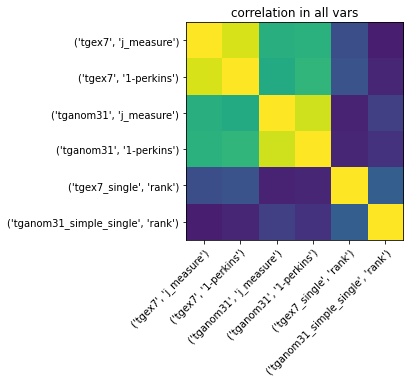

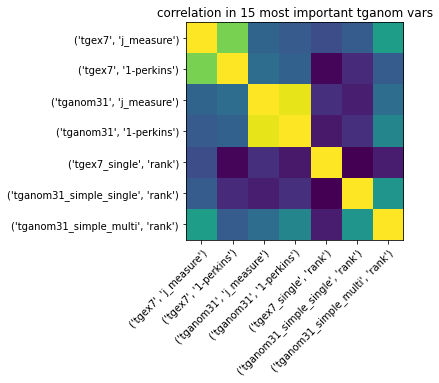

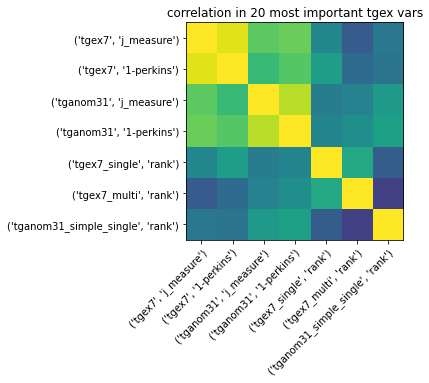

In [94]:
df_allvars = lead1215.drop(['tgex7_multi','tganom31_simple_multi'], axis = 1).dropna(how = 'any') # Drops the tg-anom 31 and z-reg 21 -1
cormatrix(df_allvars, title = 'correlation in all vars')
plt.show()
df_15vars = lead1215.drop(['tgex7_multi'], axis = 1).dropna(how = 'any')
cormatrix(df_15vars, title = 'correlation in 15 most important tganom vars')
plt.show()
df_20vars = lead1215.drop(['tganom31_simple_multi'], axis = 1).dropna(how = 'any')
cormatrix(df_20vars, title = 'correlation in 20 most important tgex vars')
plt.show()

* The single selection set of tgex7 and tg-anom31 do not corrspond well. 
* The simple tganom31 multiset corresponds better to the tgex7 j-measure than the tgex7 multiset itself. In correspondance to tganom31 j-measure they seem equal.

### Shallow multipass vs tg-ex7 and deeper multipass vs tg-ex7

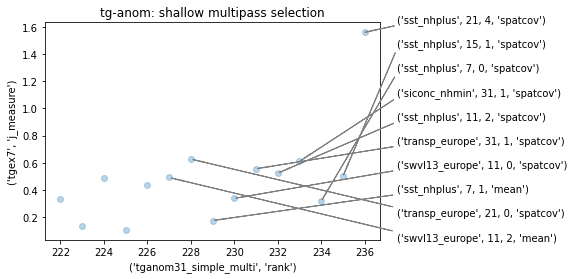

In [96]:
scatter(lead1215.sort_values(('tganom31_simple_multi','rank'), ascending = False), xcol = ('tganom31_simple_multi','rank',), ycol = ('tgex7','j_measure'), 
        title = 'tg-anom: shallow multipass selection')
plt.show()

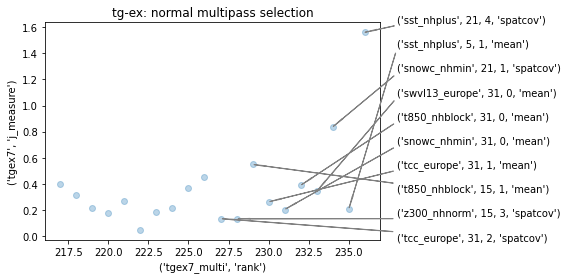

In [97]:
scatter(lead1215.sort_values(('tgex7_multi','rank'), ascending = False), xcol = ('tgex7_multi','rank',), ycol = ('tgex7','j_measure'), 
        title = 'tg-ex: normal multipass selection')
plt.show()

* tganom + simple selects for much more spatcovs than tg-ex. Is that due to the shallowness or due to the fact of tg-anom?
* tg-ex multipass has more predictors below the 0.4 j-measure importance. 

### Tg-anom vs Tg-ex in j-measure

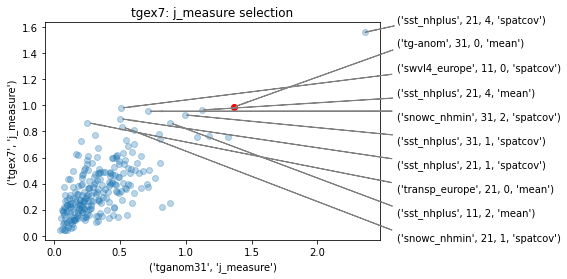

In [99]:
scatter(lead1215.sort_values(('tgex7','j_measure'), ascending = False), xcol = ('tganom31','j_measure'), ycol = ('tgex7','j_measure'), 
        title = 'tgex7: j_measure selection')
plt.show()

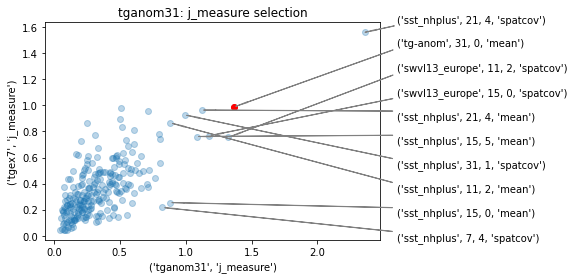

In [100]:
scatter(lead1215.sort_values(('tganom31','j_measure'), ascending = False), xcol = ('tganom31','j_measure'), ycol = ('tgex7','j_measure'), 
        title = 'tganom31: j_measure selection')
plt.show()

* Both have the same top two predictors. the gmst is very prominent. sst_nhplus 21.4 is selected with both mean and spatcov.
* the amount of means selected for is more or less equal (4 vs 5) this gives the hint that the higher amount of multipass spatcovs might be due to the shallowness.
* swvl13 is completely lacking in tg-ex. But tg-ex7 does have swvl4

## Leadtime 12-15, full spatcov projections
New series with continuous projection instead of duplication. The real benefit will probably occur when more leadtimes are pooled. E.g. 11-15. 
Current selections for:
* tganom31 > q0.5
* tganom31 > q0.75
* tganom21 > q0.5
* tgex7
* tgex5

Shared predictors in the top 15 (tganom21, tgex5, tgex7):
* sst_nhplus.21.4.spatcov (west pacific)
* sst_nhplus.5.1.mean (atlantic and ostzee)
* z.21.[1,2].mean
* t850_nhblock.21.0.mean (only the +- median targets, tropical belt + sahel + indian ocean)
* t850_nhblock.15.1.[spatcov,mean] (only the west sahel banana)
* snowc_nhmin.21.1.spatcov (only the tg-exes, east eurasia)

In [4]:
# directory with the fully projected versions.
def load_sequential(name: str):
    basepath = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/')
    temp = pd.read_csv(basepath / f'{name}.csv', index_col = 0, header = 0)
    collapse_restore_multiindex(temp, axis = 1, names = ['variable','timeagg','clustid','metric'], dtypes = [str,int,int,str], inplace = True)
    return temp

def load_sequential_imps(name: str, npreds: int = None):
    """
    Loads the sequential forward importances. (Ranks)
    can be single (lots of predictors) or multi (only n_depth of predictors)
    you can supply the total number of predictors (not inferable from size of the multi file)
    """
    temp = load_sequential(name = name)
    if (npreds is None):
        npreds = len(temp.columns)
    ranks = npreds - temp.loc['rank']
    return ranks

def percentual_improvement(name: str):
    """Multipass change in the scores"""
    assert '_multi_' in name, f'Can only be computed on a multipass file. Check {name}'
    temp = load_sequential(name = name).loc['rps']
    old = temp.iloc[:-1]
    old.index = temp.index[1:] # The score upon which the predictor (index) should improve
    new = temp.iloc[1:]
    return((new-old)/old * 100)

In [5]:
tgex7 = load_sequential_imps(name = 'tg-ex-q0.75-21D_ge7D_sep12-15_multi_d20_b3')
tgex5 = load_sequential_imps(name = 'tg-ex-q0.75-21D_ge5D_sep12-15_multi_d20_b3')
tganom21 = load_sequential_imps(name = 'tg-anom_JJA_45r1_21D-roll-mean_q05_sep12-15_multi_d20_b3')
tganom31q05 = load_sequential_imps(name = 'tg-anom_JJA_45r1_31D-roll-mean_q05_sep12-15_multi_d20_b3')
tganom31q075 = load_sequential_imps(name = 'tg-anom_JJA_45r1_31D-roll-mean_q075_sep12-15_multi_d20_b3')

In [9]:
tgex7.index.intersection(tgex5.index)

MultiIndex([(   'sst_nhplus',  5, 1,    'mean'),
            (   'sst_nhplus', 21, 4, 'spatcov'),
            (  'snowc_nhmin', 21, 1, 'spatcov'),
            ('transp_europe',  5, 0,    'mean')],
           names=['variable', 'timeagg', 'clustid', 'metric'])

In [13]:
tgex7.index.intersection(tganom21.index)

MultiIndex([(  'sst_nhplus',  5, 1,    'mean'),
            (  'sst_nhplus', 21, 4, 'spatcov'),
            ('t850_nhblock', 11, 1,    'mean'),
            (           'z', 21, 1,    'mean'),
            (  'sst_nhplus', 21, 5,    'mean')],
           names=['variable', 'timeagg', 'clustid', 'metric'])

In [14]:
tgex5.index.intersection(tganom21.index)

MultiIndex([(  'sst_nhplus', 21, 4, 'spatcov'),
            (  'sst_nhplus',  5, 1,    'mean'),
            ('t850_nhblock', 21, 0,    'mean')],
           names=['variable', 'timeagg', 'clustid', 'metric'])

When requiring a 3 percent improvement in the score these would be the subsets coming from multipass.
Note that sst.21.4.spatcov is not visible for tgex5 and tganom21, because it is the first predictor.

In [29]:
percentual_improvement(name = 'tg-ex-q0.75-21D_ge7D_sep12-15_multi_d20_b3').iloc[:6]

variable      timeagg  clustid  metric 
sst_nhplus    5        1        mean      -6.886425
              21       4        spatcov   -7.146864
t850_nhblock  15       1        spatcov   -4.995407
z300_nhnorm   11       2        mean      -4.989912
snowc_nhmin   21       1        spatcov   -2.907428
tcc_europe    5        0        mean      -3.858216
Name: rps, dtype: float64

In [27]:
percentual_improvement(name = 'tg-ex-q0.75-21D_ge5D_sep12-15_multi_d20_b3').iloc[:7]

variable       timeagg  clustid  metric 
sst_nhplus     5        1        mean      -13.165972
               11       1        spatcov    -6.306855
transp_europe  21       0        mean       -7.679694
t850_nhblock   21       0        mean       -9.068991
z300_nhnorm    15       0        mean       -7.046908
snowc_nhmin    31       0        mean       -4.946063
transp_europe  31       1        spatcov    -3.307307
Name: rps, dtype: float64

In [33]:
percentual_improvement(name = 'tg-anom_JJA_45r1_21D-roll-mean_q05_sep12-15_multi_d20_b3').iloc[:7]

variable      timeagg  clustid  metric 
t850_nhblock  21       0        mean      -6.822324
z             21       1        mean      -6.611303
sst_nhplus    15       7        spatcov   -4.104833
snowc_nhmin   21       2        mean      -3.620376
t850_nhblock  15       0        spatcov   -3.627619
                       1        mean      -3.030899
sst_nhplus    5        1        mean      -3.732357
Name: rps, dtype: float64

In [37]:
tgex5_single = load_sequential_imps(name = 'tg-ex-q0.75-21D_ge5D_sep12-15_single_d20_b3')

In [39]:
tgex5_single.iloc[:10]

variable       timeagg  clustid  metric 
sst_nhplus     21       4        spatcov    236.0
transp_europe  31       0        spatcov    235.0
sst_nhplus     15       5        mean       234.0
transp_europe  21       0        spatcov    233.0
sst_nhplus     31       1        spatcov    232.0
transp_europe  21       0        mean       231.0
sst_nhplus     11       2        mean       230.0
swvl13_europe  15       2        spatcov    229.0
transp_europe  31       1        spatcov    228.0
z300_nhnorm    15       1        spatcov    227.0
Name: rank, dtype: float64

In [29]:
percentual_improvement(name = 'tg-anom_JJA_45r1_31D-roll-mean_q05_sep12-15_multi_d20_b3').iloc[:15]

variable       timeagg  clustid  metric 
sst            21       3        mean      -10.929320
t850_nhblock   21       0        mean       -6.262723
swvl13_europe  11       0        spatcov    -2.798852
sst_nhplus     3        0        spatcov    -4.243248
               15       1        spatcov    -3.849940
               11       0        spatcov    -4.802395
               15       0        mean       -3.131458
swvl13_europe  11       2        spatcov    -7.061156
siconc_nhmin   11       0        mean       -7.517441
z300_nhnorm    11       1        spatcov    -7.415805
swvl13_europe  31       1        mean       -3.435645
transp_europe  31       1        spatcov    -2.736211
t850_nhblock   31       1        spatcov    -2.759325
snowc_nhmin    7        1        mean       -1.410810
transp_europe  5        0        mean       -1.175756
Name: rps, dtype: float64

In [26]:
# This does lead to a decent tgex7 test prediction (requiring decreases)
percentual_improvement(name = 'tg-anom_JJA_45r1_31D-roll-mean_q075_sep12-15_multi_d20_b3').iloc[:15]

variable       timeagg  clustid  metric 
sst_nhplus     15       1        spatcov   -8.811107
siconc_nhmin   31       1        spatcov   -2.933593
sst_nhplus     7        0        spatcov   -5.028561
transp_europe  31       0        spatcov   -4.311051
               21       1        mean      -4.881160
mjo            1        1        rmm2      -2.250776
sst_nhplus     11       1        spatcov   -1.368028
snowc_nhmin    15       0        spatcov   -0.801480
                                 mean      -2.850505
siconc_nhmin   31       0        spatcov   -2.369522
transp_europe  31       1        spatcov   -0.646141
sst_nhplus     7        4        spatcov   -3.285786
               11       2        spatcov   -1.523245
z300_nhnorm    15       1        mean      -1.878269
sst_nhplus     7        2        spatcov   -0.858809
Name: rps, dtype: float64

In [9]:
tganom31q075

variable       timeagg  clustid  metric 
sst_nhplus     21       4        spatcov    20.0
               15       1        spatcov    19.0
siconc_nhmin   31       1        spatcov    18.0
sst_nhplus     7        0        spatcov    17.0
transp_europe  31       0        spatcov    16.0
               21       1        mean       15.0
mjo            1        1        rmm2       14.0
sst_nhplus     11       1        spatcov    13.0
snowc_nhmin    15       0        spatcov    12.0
                                 mean       11.0
siconc_nhmin   31       0        spatcov    10.0
transp_europe  31       1        spatcov     9.0
sst_nhplus     7        4        spatcov     8.0
               11       2        spatcov     7.0
z300_nhnorm    15       1        mean        6.0
sst_nhplus     7        2        spatcov     5.0
swvl13_europe  11       0        mean        4.0
z-reg          21       3        freq        3.0
t850_nhblock   31       2        spatcov     2.0
sst_nhplus     7        2   

In [12]:
tganom31_simple_multi

variable       timeagg  clustid  metric 
sst_nhplus     21       4        spatcov    236.0
               15       1        spatcov    235.0
               7        0        spatcov    234.0
siconc_nhmin   31       1        spatcov    233.0
sst_nhplus     11       2        spatcov    232.0
transp_europe  31       1        spatcov    231.0
swvl13_europe  11       0        spatcov    230.0
sst_nhplus     7        1        mean       229.0
transp_europe  21       0        spatcov    228.0
swvl13_europe  11       2        mean       227.0
transp_europe  21       1        mean       226.0
z-reg          21       3        freq       225.0
t850_nhblock   31       2        spatcov    224.0
                        1        spatcov    223.0
sst_nhplus     7        2        mean       222.0
Name: rank, dtype: float64

In [13]:
tganom31q075.index.intersection(tganom31_simple_multi.index) # The two sets are quite similar, though one is with slightly different hyperparams and a continuous projection of empirical series

MultiIndex([(   'sst_nhplus', 21, 4, 'spatcov'),
            (   'sst_nhplus', 15, 1, 'spatcov'),
            ( 'siconc_nhmin', 31, 1, 'spatcov'),
            (   'sst_nhplus',  7, 0, 'spatcov'),
            ('transp_europe', 21, 1,    'mean'),
            ('transp_europe', 31, 1, 'spatcov'),
            (   'sst_nhplus', 11, 2, 'spatcov'),
            (        'z-reg', 21, 3,    'freq'),
            ( 't850_nhblock', 31, 2, 'spatcov'),
            (   'sst_nhplus',  7, 2,    'mean')],
           names=['variable', 'timeagg', 'clustid', 'metric'])